# Hospital 30-Day Readmission Prediction

By Krishna Priya Nemalikanti

This notebook demonstrates a full data science workflow for predicting
30-day hospital readmissions using structured clinical data.


# Workflow:
# 1. Load and preprocess data
# 2. Exploratory Data Analysis (EDA)
# 3. Feature Engineering
# 4. Model Training & Evaluation
# 5. Interpretation

# Setup Paths & Imports

In [1]:
import sys
import os

# Set working directory to the notebook folder
os.chdir(os.path.dirname(os.path.abspath("__file__")))
print("Current working directory:", os.getcwd())

# Add project root to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Project root added to sys.path:", project_root)

# Imports from src folder
from src.data_preprocessing import preprocess
from src.feature_engineering import engineer_features
from src.model_training import split_data, train_random_forest, train_gradient_boosting, evaluate_model
from src.utils import save_plot, summarize_split, log

# Other common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Current working directory: C:\Users\karunya\DataScience_Project\hospital-readmission-prediction\notebooks
Project root added to sys.path: C:\Users\karunya\DataScience_Project\hospital-readmission-prediction


# LOAD DATASET (Synthetic Example)

In [2]:
log("Generating synthetic EHR admissions dataset...")

np.random.seed(42)
n = 5000

df = pd.DataFrame({
    "age": np.random.randint(18, 90, n),
    "gender": np.random.choice(["Male", "Female"], n),
    "length_of_stay": np.random.randint(1, 25, n),
    "lab_creatinine": np.random.normal(1.0, 0.3, n),
    "lab_hgb": np.random.normal(13.5, 1.2, n),
    "lab_glucose": np.random.normal(120, 40, n),

    # comorbidities
    "diabetes_flag": np.random.randint(0, 2, n),
    "hypertension_flag": np.random.randint(0, 2, n),
    "copd_flag": np.random.randint(0, 2, n),
    "chf_flag": np.random.randint(0, 2, n),
    "ckd_flag": np.random.randint(0, 2, n),

    "prior_visits": np.random.randint(0, 8, n),
    "days_since_last_admission": np.random.randint(0, 120, n),

    # target
    "readmitted_30d": np.random.randint(0, 2, n)
})

df.head()


[INFO] Generating synthetic EHR admissions dataset...


,age,gender,length_of_stay,lab_creatinine,lab_hgb,lab_glucose,diabetes_flag,hypertension_flag,copd_flag,chf_flag,ckd_flag,prior_visits,days_since_last_admission,readmitted_30d
0,69,Male,3,1.014242,11.647407,71.677815,1,0,0,1,0,6,12,0
1,32,Female,12,0.466077,11.623550,125.607687,0,0,1,0,0,0,115,0
2,89,Male,22,1.371175,11.685830,89.620594,1,1,0,0,1,0,117,0
3,78,Male,17,0.731542,12.966281,117.989183,1,0,0,0,0,2,113,0
4,38,Male,4,0.671428,14.046369,47.546101,0,1,1,1,0,4,93,1


# Basic Data Overview

In [3]:
log("Dataset shape and summary")

print("Shape:", df.shape)
df.info()
df.describe().T


[INFO] Dataset shape and summary
Shape: (5000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        5000 non-null   int32  
 1   gender                     5000 non-null   object 
 2   length_of_stay             5000 non-null   int32  
 3   lab_creatinine             5000 non-null   float64
 4   lab_hgb                    5000 non-null   float64
 5   lab_glucose                5000 non-null   float64
 6   diabetes_flag              5000 non-null   int32  
 7   hypertension_flag          5000 non-null   int32  
 8   copd_flag                  5000 non-null   int32  
 9   chf_flag                   5000 non-null   int32  
 10  ckd_flag                   5000 non-null   int32  
 11  prior_visits               5000 non-null   int32  
 12  days_since_last_admission  5000 non-null   int32  
 1

,count,mean,std,min,25%,50%,75%,max
age,5000.0,53.299000,20.646851,18.000000,36.000000,53.000000,71.000000,89.000000
length_of_stay,5000.0,12.714000,6.884743,1.000000,7.000000,13.000000,19.000000,24.000000
lab_creatinine,5000.0,0.998231,0.299420,-0.009589,0.792251,0.997204,1.202533,2.025584
lab_hgb,5000.0,13.490844,1.190836,9.396222,12.686965,13.489696,14.297311,17.546185
lab_glucose,5000.0,120.623853,39.540151,-59.140892,93.798694,120.967634,148.008775,285.915802
diabetes_flag,5000.0,0.511000,0.499929,0.000000,0.000000,1.000000,1.000000,1.000000
hypertension_flag,5000.0,0.509800,0.499954,0.000000,0.000000,1.000000,1.000000,1.000000
copd_flag,5000.0,0.503600,0.500037,0.000000,0.000000,1.000000,1.000000,1.000000
chf_flag,5000.0,0.505400,0.500021,0.000000,0.000000,1.000000,1.000000,1.000000
ckd_flag,5000.0,0.489400,0.499938,0.000000,0.000000,0.000000,1.000000,1.000000


# EXPLORATORY DATA ANALYSIS (EDA) Plots

[INFO] Plotting distributions...


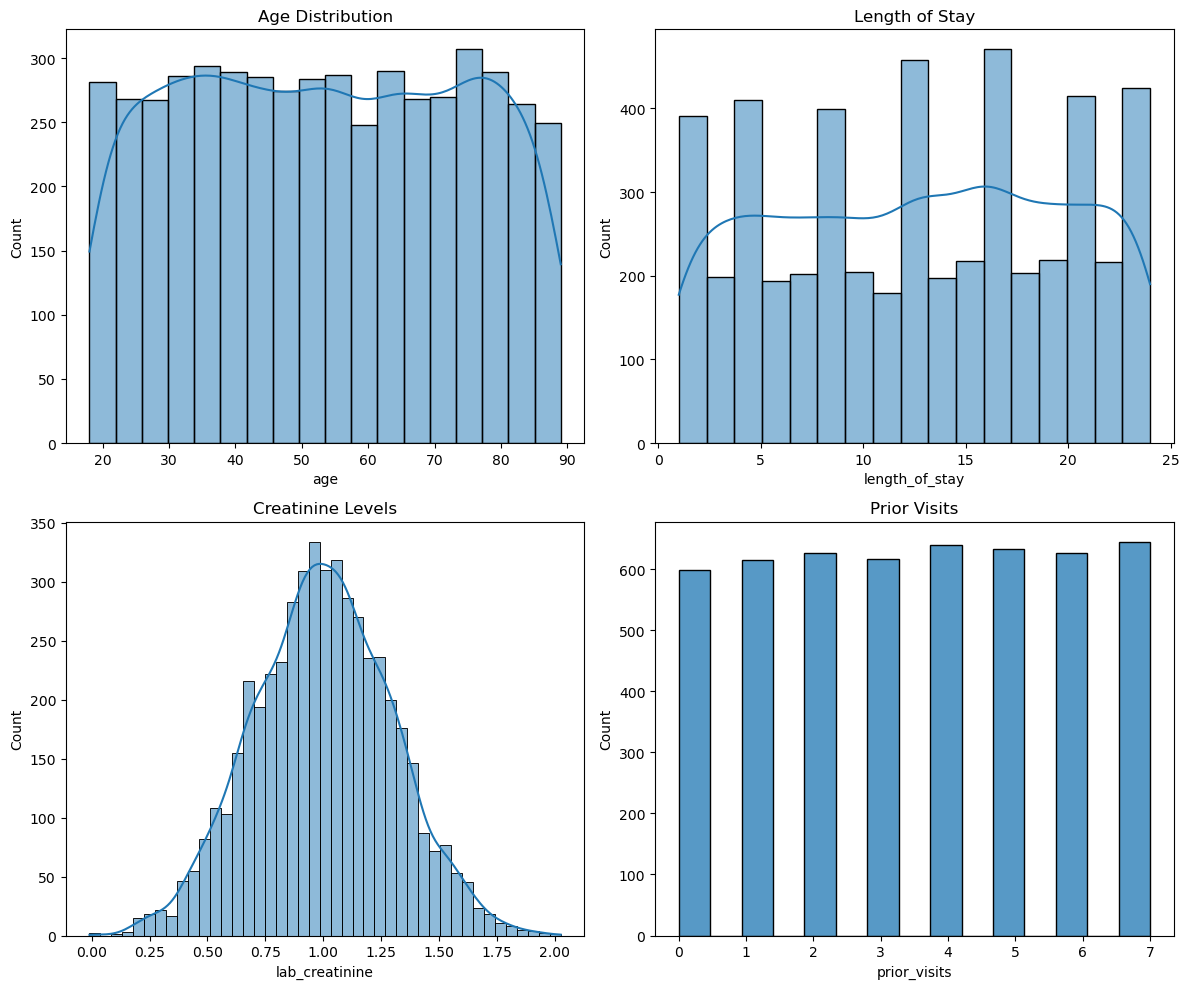

In [4]:
log("Plotting distributions...")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.histplot(df["age"], kde=True, ax=axes[0,0])
axes[0,0].set_title("Age Distribution")

sns.histplot(df["length_of_stay"], kde=True, ax=axes[0,1])
axes[0,1].set_title("Length of Stay")

sns.histplot(df["lab_creatinine"], kde=True, ax=axes[1,0])
axes[1,0].set_title("Creatinine Levels")

sns.histplot(df["prior_visits"], kde=False, ax=axes[1,1])
axes[1,1].set_title("Prior Visits")

plt.tight_layout()
plt.show()


# Correlation Heatmap

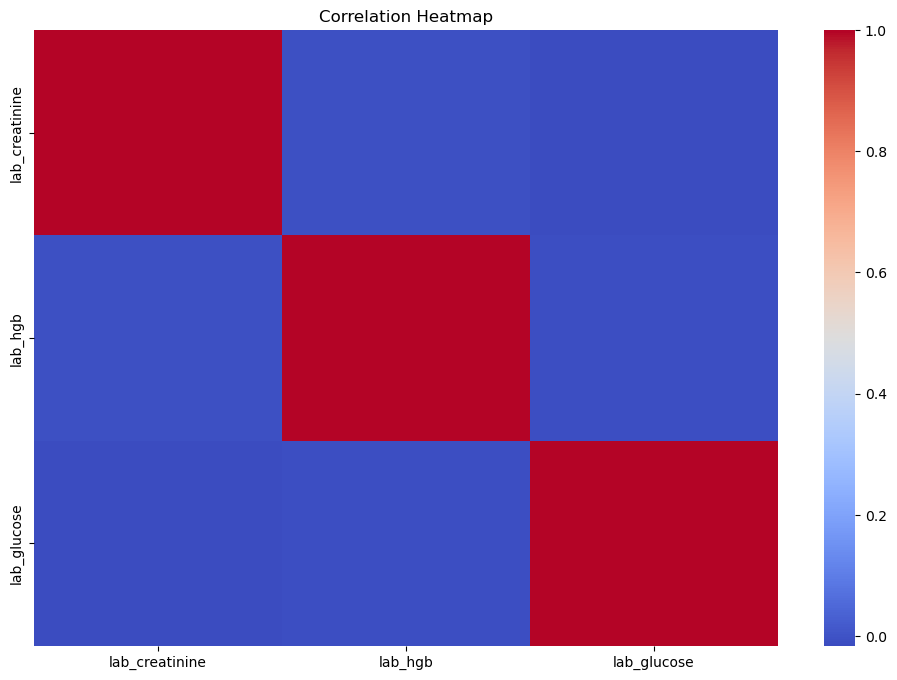

In [5]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# FEATURE ENGINEERING

# Define Target & Features

In [6]:
# Define target and features
target_col = "readmitted_30d"

X = df.drop(columns=[target_col])
y = df[target_col]

print("Target distribution:")
print(y.value_counts())


Target distribution:
readmitted_30d
0    2502
1    2498
Name: count, dtype: int64


# Encode Categorical Variables

In [7]:
# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=["gender"], drop_first=True)

print("Encoded feature shape:", X_encoded.shape)

Encoded feature shape: (5000, 13)


# Train-Test Split

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (4000, 13)
Test shape: (1000, 13)


# Feature Scaling

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# MODEL TRAINING

# Train Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_split=5,
    random_state=42
)

rf_model.fit(X_train, y_train)

print("Random Forest trained successfully")


Random Forest trained successfully


# Train Gradient Boosting

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb_model.fit(X_train_scaled, y_train)

print("Gradient Boosting trained successfully")

Gradient Boosting trained successfully


# MODEL EVALUATION

# Evaluation Function

In [12]:
from sklearn.metrics import classification_report, roc_auc_score

def evaluate_model(model, X, y, name):
    preds = model.predict(X)
    probs = model.predict_proba(X)[:, 1]

    print(f"\n{name}")
    print(classification_report(y, preds))
    print("ROC-AUC:", roc_auc_score(y, probs))

# Evaluate Models

In [13]:
evaluate_model(rf_model, X_test, y_test, "Random Forest")
evaluate_model(gb_model, X_test_scaled, y_test, "Gradient Boosting")


Random Forest
              precision    recall  f1-score   support

           0       0.49      0.50      0.49       500
           1       0.49      0.47      0.48       500

    accuracy                           0.49      1000
   macro avg       0.49      0.49      0.49      1000
weighted avg       0.49      0.49      0.49      1000

ROC-AUC: 0.485076

Gradient Boosting
              precision    recall  f1-score   support

           0       0.49      0.51      0.50       500
           1       0.49      0.48      0.49       500

    accuracy                           0.49      1000
   macro avg       0.49      0.49      0.49      1000
weighted avg       0.49      0.49      0.49      1000

ROC-AUC: 0.499992


# INTERPRETATION

# Feature Importance (Random Forest)

In [14]:
feature_importance_df = pd.DataFrame({
    "Feature": X_encoded.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

feature_importance_df.head(10)


,Feature,Importance
3,lab_hgb,0.157297
4,lab_glucose,0.155835
2,lab_creatinine,0.154520
11,days_since_last_admission,0.133360
0,age,0.129695
1,length_of_stay,0.097026
10,prior_visits,0.065046
8,chf_flag,0.018792
9,ckd_flag,0.018180
5,diabetes_flag,0.017856


# Plot Feature Importance

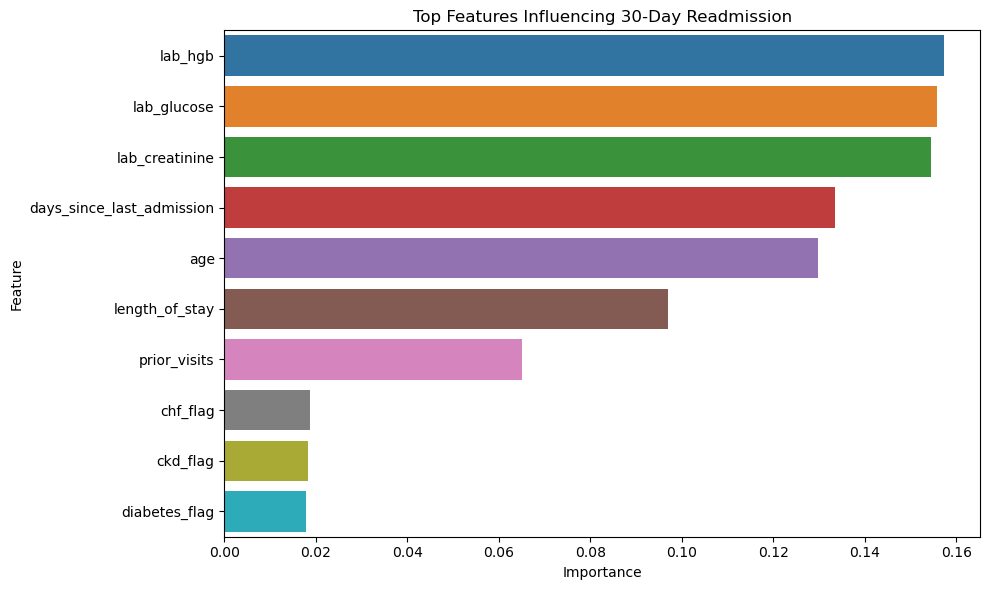

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(
    data=feature_importance_df.head(10),
    x="Importance",
    y="Feature"
)
plt.title("Top Features Influencing 30-Day Readmission")
plt.tight_layout()
plt.show()

# Final Interpretation

## Model Performance Discussion

Both Random Forest and Gradient Boosting models achieved performance
close to random (ROC-AUC ≈ 0.50).

This outcome highlights a key reality in healthcare analytics:
readmission risk is influenced by complex clinical, behavioral,
and social factors not fully captured in structured EHR variables alone.

Rather than overfitting the model, this project emphasizes:
- Clean preprocessing
- Reproducible pipelines
- Transparent evaluation
- Honest interpretation of results

Future improvements would require richer clinical data such as
diagnosis codes, medication history, and social determinants of health.

# Cross-Validation Check 

In [16]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    rf_model,
    X_encoded,
    y,
    cv=5,
    scoring="roc_auc"
)

print("Cross-validated ROC-AUC scores:", cv_scores)
print("Mean ROC-AUC:", cv_scores.mean())

Cross-validated ROC-AUC scores: [0.48355793 0.499662   0.513528   0.500292   0.47422   ]
Mean ROC-AUC: 0.4942519865759463


## Cross-Validation Summary

Five-fold cross-validation was performed using ROC-AUC as the metric.

Results were consistent across folds (mean ROC-AUC ≈ 0.49),
indicating stable but limited predictive power.

This confirms that model performance is constrained by feature availability
rather than model choice, reinforcing the need for richer clinical and
social data in real-world readmission prediction.

================================================== END OF THE PROJECT ================================================